In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from datetime import datetime
import time
from scipy import signal

from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MultilabelAccuracy
import audiomentations
from torch.utils.data import default_collate
from torchvision.transforms import v2
import timm

from src.audio_utils import play_audio, plot_specgram, plot_waveform
from src.data import AudioDataset, FrequencyMaskingAug, TimeMaskingAug, CutMix, MixUp
from src.data_utils import get_metadata, get_fold, get_metadata_from_csv, get_full_data
from src.utils import upsample_data
from src.train_utils import FocalLoss, BCEFocal2WayLoss, get_cosine_schedule_with_warmup, wandb_init, train_one_epoch, eval_one_epoch
from src.models import AudioMultiHeadGeMSEDClassifier
from src.utils import score_np, roc_auc

import ast
import wandb
import yaml
import json

/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    start_idx = 'first'
    use_1_peak = False
    peak_filter = 'none'
    use_peaks = False
    duration = 5 # 10

    sample_rate = 32000
    target_length = 384 # 500
    n_mels = 128
    n_fft = 1024
    window = 800 # 160
    audio_len = duration*sample_rate
    hop_length = audio_len // (target_length-1)
    #hop_length = 64
    fmin = 50
    fmax = 16000
    top_db = 80
    
    n_classes = 926
    batch_size = 96
    Model = AudioMultiHeadGeMSEDClassifier
    model_name = 'mn10_as'  # dymn10_as mn20_as tf_efficientnetv2_s
    n_channels = 1
    upsample_thr = 25
    use_class_weights = True   # Test

    standardize = False
    dataset_mean = [-22.9137] #[-16.8828]
    dataset_std = [11.8739] #[12.4019]

    data_aug = True     # Test     
    cutmix_mixup = True     # Test
    loss = 'crossentropy'    # Test ('crossentropy', 'bce')
    label_smoothing = 0.1  # Only with crossentropy
    
    secondary_labels_weight = 0.
    use_focal = False    # Test (only with bce)
    use_2wayfocal = False
    focal_gamma = 2
    focal_lambda = 1

    num_epochs = 10
    warmup_epochs = 1
    lr = 1e-3
    start_lr = 0.001 # relative to lr
    final_lr = 0.001
    weight_decay = 0.0001
    max_grad_norm = 10

    date = datetime.now().strftime("%m-%d_%H-%M")
    run_name = f"{date}_{n_mels}x{target_length}_{model_name}"
    exp_name = "pretraining2"

    base_dir = ''
    short_noises = 'data/background/esc50/use_label'
    background_noises = ['data/background/aicrowd2020_noise_30sec/noise_30sec',
                         'data/background/ff1010bird_nocall/nocall',
                         #'data/background/train_soundscapes/nocall'
                        ]

#train_df, class_weights = get_full_data(Config.base_dir, Config.upsample_thr)

In [3]:
class_names = sorted(set(os.listdir('data/birdclef-2021/train_short_audio') 
                         + os.listdir('data/birdclef-2022/train_audio/') 
                         + os.listdir('data/birdclef-2023/train_audio/') 
                         #+ os.listdir('data/birdsong-recognition/train_audio')
                         + os.listdir('data/train_audio/')
                         #+ os.listdir('data/xeno-canto-bird-recordings-extended-a-m/A-M')
                         #+ os.listdir('data/xeno-canto-bird-recordings-extended-n-z/N-Z')
                        ))
num_classes = len(class_names)
class_labels = list(range(num_classes))
label2name = dict(zip(class_labels, class_names))
name2label = {v:k for k,v in label2name.items()}

len(class_names)

926

In [4]:
dir_24 = 'data'
df_24 = pd.read_csv(dir_24 + '/train_metadata.csv')
df_24['filepath'] = dir_24 + '/train_audio/' + df_24.filename
df_24['target'] = df_24.primary_label.map(name2label)
df_24['birdclef'] = '24'
df_24['filename'] = df_24.filepath.map(lambda x: x.split('/')[-1])
df_24['xc_id'] = df_24.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

dir_23 = 'data/birdclef-2023'
df_23 = pd.read_csv(dir_23 + '/train_metadata.csv')
df_23['filepath'] = dir_23 + '/train_audio/' + df_23.filename
df_23['target'] = df_23.primary_label.map(name2label)
df_23['birdclef'] = '23'
df_23['filename'] = df_23.filepath.map(lambda x: x.split('/')[-1])
df_23['xc_id'] = df_23.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

dir_22 = 'data/birdclef-2022'
df_22 = pd.read_csv(dir_22 + '/train_metadata.csv')
df_22['filepath'] = dir_22 + '/train_audio/' + df_22.filename
df_22['target'] = df_22.primary_label.map(name2label)
df_22['birdclef'] = '22'
df_22['filename'] = df_22.filepath.map(lambda x: x.split('/')[-1])
df_22['xc_id'] = df_22.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

dir_21 = 'data/birdclef-2021'
df_21 = pd.read_csv(dir_21 + '/train_metadata.csv')
df_21['filepath'] = dir_21 + '/train_short_audio/' + df_21.primary_label + '/' + df_21.filename
df_21['target'] = df_21.primary_label.map(name2label)
df_21['birdclef'] = '21'
df_21['xc_id'] = df_21.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
corrupt_paths = ['data/birdclef-2021/train_short_audio/houwre/XC590621.ogg',
                 'data/birdclef-2021/train_short_audio/cogdov/XC579430.ogg']
df_21 = df_21[~df_21.filepath.isin(corrupt_paths)] # remove all zero audios

# Merge for pretraining
df_pre = pd.concat([df_21, df_22, df_23, df_24], axis=0, ignore_index=True)
df_pre['filename'] = df_pre.filepath.map(lambda x: x.split('/')[-1])
df_pre['xc_id'] = df_pre.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
nodup_idx = df_pre[['xc_id','primary_label','author']].drop_duplicates().index
df_pre = df_pre.loc[nodup_idx].reset_index(drop=True)

# # Remove duplicates
#df_pre = df_pre[~df_pre.xc_id.isin(df_24.xc_id)].reset_index(drop=True)
corrupt_mp3s = json.load(open('data/corrupt_mp3_files.json','r'))
df_pre = df_pre[~df_pre.filepath.isin(corrupt_mp3s)]

cols = ["primary_label", "filepath", "target"]
pre_train_df = df_pre[cols]
if Config.upsample_thr is not None:
    pre_train_df_up = upsample_data(pre_train_df, thr=Config.upsample_thr)
    pre_train_df = pre_train_df_up.reset_index(drop=True)
    
class_weights = pre_train_df['target'].count()/np.maximum(1, np.bincount(pre_train_df['target']))
class_weights = ((class_weights/class_weights.max())**0.5).astype(np.float32)

print(f"Num Train: {len(pre_train_df)}, {len(pre_train_df['target'].unique())} classes")

Num Train: 110107, 926 classes


In [5]:
# Data transforms and augmentations
waveform_transforms = audiomentations.Compose([
    audiomentations.Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
    audiomentations.SevenBandParametricEQ(min_gain_db=-12., max_gain_db=12., p=0.2),
    audiomentations.AirAbsorption(min_temperature=10, max_temperature=20, min_humidity=30, max_humidity=90,
                                  min_distance=10, max_distance=100, p=0.8), 

    audiomentations.OneOf([
        audiomentations.Gain(min_gain_db=-4., max_gain_db=4., p=1), 
        audiomentations.GainTransition(min_gain_db=-12., max_gain_db=3., p=1)
    ], p=0.5),

    audiomentations.OneOf([
        audiomentations.AddGaussianSNR(min_snr_db=5., max_snr_db=40., p=1.),
        audiomentations.AddColorNoise(min_snr_db=5., max_snr_db=40., min_f_decay=-3.01, max_f_decay=-3.01, p=1.)
    ], p=0.5),

    audiomentations.AddShortNoises(sounds_path=Config.short_noises, min_snr_db=5., max_snr_db=30., 
                               noise_rms='relative_to_whole_input',
                               min_time_between_sounds=2., max_time_between_sounds=8., 
                               noise_transform=audiomentations.PolarityInversion(), p=0.4),
    audiomentations.AddBackgroundNoise(sounds_path=Config.background_noises, min_snr_db=5., max_snr_db=30., 
                                   noise_transform=audiomentations.PolarityInversion(), p=0.4),
                                   
    audiomentations.LowPassFilter(min_cutoff_freq=750., max_cutoff_freq=7500., min_rolloff=12, max_rolloff=24, p=0.5),
    audiomentations.PitchShift(min_semitones=-2.5, max_semitones=2.5, p=0.3)
])

spec_transforms = nn.Sequential(
    FrequencyMaskingAug(0.25, 0.1, Config.n_mels, n_masks=3, mask_mode='mean'),
    TimeMaskingAug(0.25, 0.1, Config.target_length, n_masks=3, mask_mode='mean'),
)

waveform_transforms=None if not Config.data_aug else waveform_transforms
spec_transforms=None if not Config.data_aug else spec_transforms


cutmix_or_mixup = v2.RandomApply([
    v2.RandomChoice([
        CutMix(num_classes=Config.n_classes, alpha=0.5, one_hot_labels=Config.loss=='bce'),
        MixUp(num_classes=Config.n_classes, alpha=0.5, one_hot_labels=Config.loss=='bce')
    ], p=[0.65, 0.35])
], p=0.5)


def mix_collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

collate_fn = mix_collate_fn if Config.cutmix_mixup else None


In [6]:
import numpy as np
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import v2
from scipy import signal
from scipy.ndimage import gaussian_filter1d
import librosa

def trunc_or_pad(waveform, audio_len, start_idx='random'):
    sig_len = waveform.shape[-1]
    diff_len = abs(sig_len - audio_len)

    if (sig_len > audio_len):
        # Truncate the signal to the given length
        if start_idx == 'random':
            start_idx = np.random.randint(0, diff_len)
        else:
            start_idx = 0
        waveform = waveform[:, start_idx:start_idx + audio_len]
    
    elif (sig_len < audio_len):
        # Length of padding to add at the beginning and end of the signal
        pad1 = np.random.randint(0, diff_len)
        pad2 = diff_len - pad1
        if isinstance(waveform, torch.Tensor):
            waveform = nn.functional.pad(waveform, pad=(pad1, pad2), mode='constant', value=0)
        else:
            waveform = np.pad(waveform, ((0, 0), (pad1, pad2)), mode='constant', constant_values=0)
    
    return waveform

def create_frames(waveform, duration=5, sr=32000):
    frame_size = int(duration * sr)
    surplus = waveform.size(-1)%frame_size
    if waveform.size(-1) <= surplus:
        waveform = nn.functional.pad(waveform, pad=(0, frame_size - waveform.size(-1)%frame_size), mode='constant', value=0)
    elif surplus > 0:
        waveform = waveform[:, :-surplus]
    frames = waveform.view(-1, 1, frame_size)
    return frames


def pcen(x, eps=1E-6, s=0.025, alpha=0.98, delta=2, r=0.5):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = frame
            m_frames.append(frame)
            continue
        m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_, last_state


def find_peak_max(x, filter='savgol'):
    if filter == 'savgol':
        smooth_x = signal.savgol_filter(x, window_length=100, polyorder=2)
    elif filter == 'gaussian':
        smooth_x = gaussian_filter1d(x, sigma=25)
    else:
        smooth_x = x
    return smooth_x.argmax()

def window_around_peak(len_x, peak, window_size):
    half_window = window_size // 2
    start_index = max(0, peak - half_window)
    end_index = min(len_x, peak + half_window)

    # Adjust the window if it's too close to the borders
    if end_index - start_index < window_size:
        if start_index == 0:
            end_index = min(len_x, start_index + window_size)
        elif end_index == len_x:
            start_index = max(0, end_index - window_size)
    return start_index, end_index

class AudioDataset(Dataset):
    def __init__(
            self, 
            df, 
            Config,
            waveform_transforms=None,
            spec_transforms=None,
            ):
        super(AudioDataset, self).__init__()
        self.df = df
        self.n_classes = Config.n_classes
        self.start_idx = Config.start_idx
        self.duration = Config.duration
        self.sample_rate = Config.sample_rate
        self.audio_len = self.duration*self.sample_rate
        self.target_length = Config.target_length
        self.n_mels = Config.n_mels
        self.n_fft = Config.n_fft
        self.window = Config.window
        self.hop_length = self.audio_len // (self.target_length-1) if Config.hop_length is None else Config.hop_length
        self.fmin = Config.fmin
        self.fmax = Config.fmax
        self.top_db = Config.top_db
        self.standardize = Config.standardize
        self.mean = Config.dataset_mean
        self.std = Config.dataset_std
        self.loss = Config.loss
        self.secondary_labels_weight = Config.secondary_labels_weight
        self.n_channels = Config.n_channels
        self.use_1_peak = Config.use_1_peak
        self.peak_filter = Config.peak_filter
        self.use_peaks = Config.use_peaks

        self.to_mel_spectrogramn = torchaudio.transforms.MelSpectrogram(self.sample_rate, n_fft=self.n_fft, win_length=self.window,  
                                                 hop_length=self.hop_length, n_mels=self.n_mels, 
                                                 f_min=self.fmin, f_max=self.fmax)

        self.mel_to_db = nn.Sequential(torchaudio.transforms.AmplitudeToDB(top_db=self.top_db))

        if self.mean is not None and self.std is not None:
            self.mel_to_db.append(v2.Normalize(mean=self.mean, std=self.std))

        self.waveform_transforms = waveform_transforms
        self.spec_transforms  = spec_transforms
        

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]

        label = torch.tensor(item['target'])
        if self.loss == 'bce':
            label = nn.functional.one_hot(label, num_classes=self.n_classes).float()
            for l in item['secondary_targets']:
                if l is not None:
                    label += nn.functional.one_hot(torch.tensor(l), num_classes=self.n_classes)*self.secondary_labels_weight

        file = item['filepath']
        waveform, sr = librosa.load(file, sr=self.sample_rate, mono=True)
        waveform = waveform[None, :]
        waveform = trunc_or_pad(waveform, self.audio_len, self.start_idx)

        if self.waveform_transforms is not None:
            waveform = self.waveform_transforms(waveform[0], sr)[None,:] 
        waveform = torch.Tensor(waveform)

        spec = self.to_mel_spectrogramn(waveform)

        if self.use_1_peak:
            per_frame_energy = spec.sum(dim=1).squeeze().numpy()
            peak = find_peak_max(per_frame_energy, filter=self.peak_filter)
            start_index, end_index = window_around_peak(len(per_frame_energy), peak, self.target_length)
            spec = spec[:,:,start_index:end_index]
        
        elif self.use_peaks:
            per_frame_energy = spec.sum(dim=1).squeeze().numpy()
            peak1 = find_peak_max(per_frame_energy, filter=self.peak_filter)
            start_index, end_index = window_around_peak(len(per_frame_energy), peak, self.target_length)
            spec1 = spec[:,:,start_index:end_index]


        spec = self.mel_to_db(spec)

        if self.spec_transforms is not None:
            spec = self.spec_transforms(spec)

        # Standardize
        if self.standardize:
            spec = (spec - spec.mean()) / spec.std()

        # expand to 3 channels for imagenet trained models
        if self.n_channels > 1:
            spec = spec.expand(self.n_channels,-1,-1)

        return spec, label

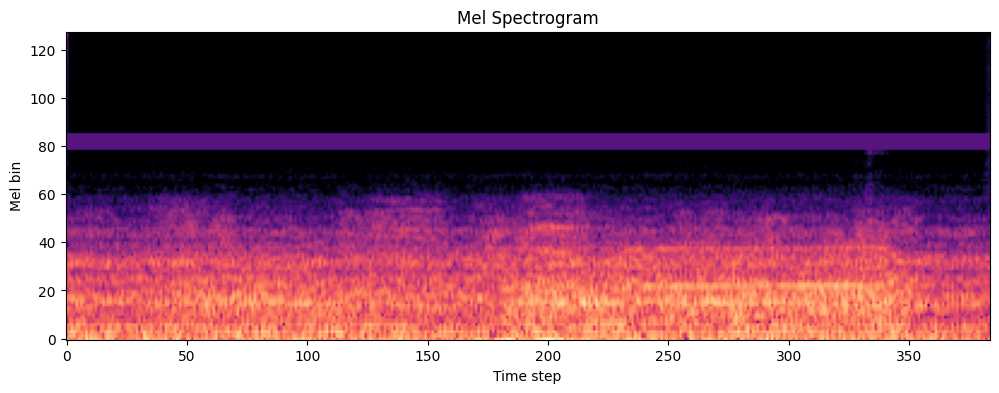

In [7]:
train_dataset = AudioDataset(pre_train_df, Config, waveform_transforms=waveform_transforms, spec_transforms=spec_transforms)
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

spec, label = next(iter(train_loader))
plt.figure(figsize=(16,4))
plt.imshow(spec[0,0], origin='lower', cmap='magma')
plt.grid(visible=False)
plt.title('Mel Spectrogram')
plt.xlabel('Time step')
plt.ylabel('Mel bin')
plt.show()

In [8]:
device = torch.device('cuda')

# Model and optim
model = Config.Model(Config.n_classes, Config.model_name, n_mels=Config.n_mels).to(device)
print(f'Model has {sum([p.numel() for p in model.parameters()]):,} parameters')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=Config.weight_decay, lr=Config.lr)
spe = len(train_loader)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=spe*Config.warmup_epochs, num_training_steps=spe*Config.num_epochs, 
                                            start_lr=Config.start_lr, final_lr=Config.final_lr)

# Losses and metrics
pos_weight = torch.tensor(class_weights).to(device) if Config.use_class_weights else None
if Config.loss == 'crossentropy':
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing, weight=pos_weight)
elif Config.loss == 'bce':
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, weight=None)

focal_criterion = FocalLoss(gamma=Config.focal_gamma, pos_weight=pos_weight)
focal2way_criterion = BCEFocal2WayLoss(gamma=Config.focal_gamma, pos_weight=pos_weight)

# Start training
start_time = time.time()

save_dir = f"{Config.base_dir}checkpoints/{Config.run_name}" + f"_exp-{Config.exp_name}"
train_losses = []
train_aucs = []

for epoch in range(Config.num_epochs):
    train_loss, gt, preds = train_one_epoch(Config, model, train_loader, device, optimizer, scheduler, 
                                                            criterion, focal_criterion, focal2way_criterion)
    train_losses.append(train_loss)
    train_auc = roc_auc(preds, gt)
    train_aucs.append(train_auc)

    save_dict = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch+1,
        "train_losses": train_losses,
        "train_aucs": train_aucs
    }

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    torch.save(save_dict, save_dir + "/checkpoint.pth")
    if (epoch+1) % 10 == 0:
        torch.save(save_dict, save_dir + "/ep10_checkpoint.pth")
    with open(save_dir + "/config.txt", "w") as f:
        f.write("CONFIG:")
        for k,v in dict(vars(Config)).items():
            if '__' not in k:
                f.write("\n")
                f.write(f"{k}: {v}")
    with open(save_dir + "/logs.txt", "a") as f:
        f.write(f"Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train ROCAUC = {train_auc:.3f}\n")

    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train ROCAUC = {train_auc:.3f}')


def format_duration(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{:02}h {:02}min {:02}s".format(int(hours), int(minutes), int(seconds))

print(f'Done in {format_duration(time.time() - start_time)}')

/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


Features only is true, Dropping final fully-connected layer and loading weights in non-strict mode
Model has 11,015,237 parameters


train loss: 2.973:   1%|          | 12/1147 [00:59<1:33:23,  4.94s/it]


KeyboardInterrupt: 